# What is the best way to estimate Social Influence?

In [95]:
import igraph as ig
import networkx as nx
import numpy as np
import pandas as pd
import time, os
from math import comb
from random import uniform, seed, choice
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from copy import deepcopy
from itertools import combinations

# ig.config['plotting.backend'] = 'matplotlib'

In [2]:
# Preprocessing mtx file
def read_mtx(path,
    skip = 0,
    comments="#",
    delimiter=None,
    create_using=None,
    nodetype=None,
    data=True,
    edgetype=None,
    encoding="utf-8",):
    """
    Inputs:
        path: file path
        skip: the number of lines that should be skipped
    Outputs:
        networkx graph
    """
    with open(path, 'r') as f:
        str_list = f.readlines()
    return nx.parse_edgelist(
        str_list[skip:],
        comments=comments,
        delimiter=delimiter,
        create_using=create_using,
        nodetype=nodetype,
        data=data,
    )

# image folder
os.makedirs("figures", exist_ok=True)


In [124]:
folder_2 = "/Users/chenxiaolong/Desktop/DSA/dataset/"
file_name_2 = folder_2 + "rt-twitter-copen/rt-twitter-copen.mtx"

folder = "/Users/chenxiaolong/Desktop/ddm/5056/final/5056_final/ca-netscience/"
file_name = folder + "ca-netscience.mtx"

dolphin_file_name = "/Users/chenxiaolong/Desktop/ddm/5056/final/dolphins/dolphins.gml"
hens_file_name = "./data/aves-hens-pecking-order/aves-hens-pecking-order.edges"

## Basic information of the network

In [4]:
# construct igraph Graph
# G_nx = read_mtx(file_name)
G_nx = nx.read_gml(dolphin_file_name)
G = ig.Graph.from_networkx(G_nx)

num_edge = G.ecount()       # number of edges
num_vertice = G.vcount()    # number of vertices
print(f"The graph has {num_vertice} vertices and {num_edge} edges.")

The graph has 62 vertices and 159 edges.


### Visualization

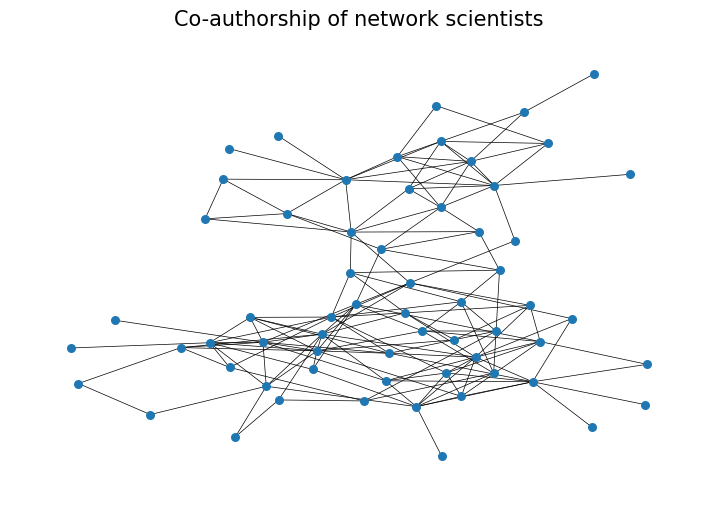

In [91]:
# igraph is not so compatible with matplotlib, so we use networkx for visualization.
fig_1 = plt.figure(figsize=(9, 6))

plt.title("Co-authorship of network scientists", size=15)
nx.draw_kamada_kawai(G_nx, node_size=30, width=0.5, with_labels=False)
plt.savefig("figures/original_g.eps")

In [92]:
# Degree Centrality Plot
from matplotlib import cm, colors

def draw_deg_heatmap(G, save_folder="figures/", fig_size=(9, 6)):
    node_color = [G.degree(n) for n in G.nodes()]
    cmap = colors.LinearSegmentedColormap.from_list('', ['w','r'])

    smap = cm.ScalarMappable(cmap=cmap)
    smap.set_array([i for i in range(0, 36)])

    plt.figure(figsize=fig_size)
    nx.draw_kamada_kawai(G, node_size=80, edgecolors='k', width=.25,
                    node_color=node_color, cmap=cmap)
    plt.colorbar(smap, aspect=50, label="Value of degree", fraction=0.1, pad=0.04, shrink=0.75)
    plt.title("Co-authorship of network scientists")
    plt.savefig(save_folder + "deg_heatmap.eps")
    plt.show()

def plot_degree_dist(G, save_folder="figures/", fig_size=(9, 6)):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.figure(figsize=fig_size)
    plt.title("Degree Distribution of the Network", size=15)
    hist_, bins_, _ = plt.hist(degrees, density=1, rwidth=0.5, bins = np.linspace(0, 40, 41))
    plt.xlabel("Degree", size=10)
    plt.ylabel("Frequency", size=10)
    plt.savefig(save_folder + "Degree_dist.eps")
    plt.show()
    return (hist_, bins_)

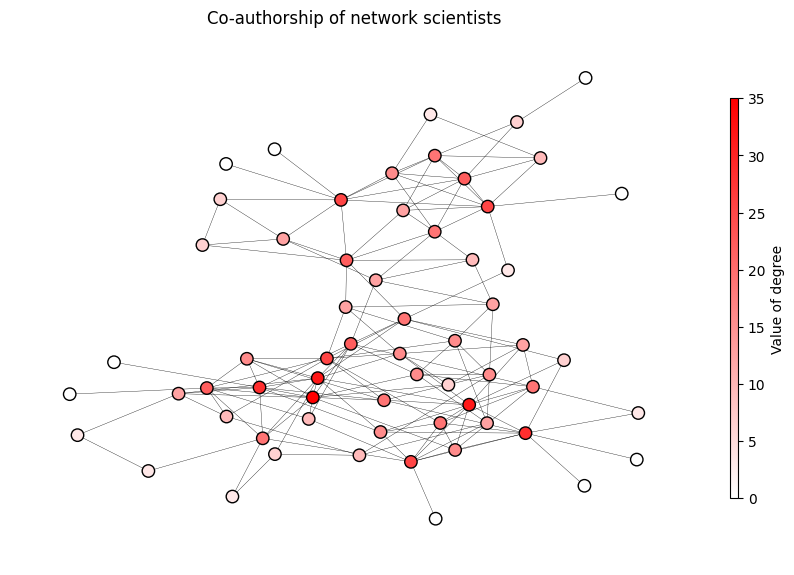

In [93]:
draw_deg_heatmap(G_nx, fig_size=(8, 16/3))

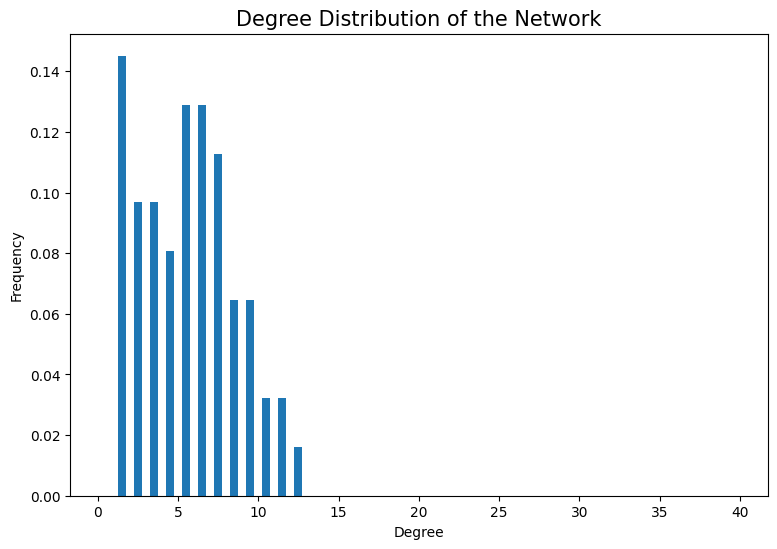

In [94]:
deg_hist, deg_bins = plot_degree_dist(G_nx)

## Independent Cascade Model

In [104]:
# Independent cascade model
# Used to compute influence spread
def IC(G, S, p=0.5, mc=1000):
    """
    Input:
        G: igraph Graph
        S: seed set
        p: probability threshold
        mc: number of MC simulations
    Output:
        average number of influenced nodes
    """
    spread = []     # The number of influenced nodes, starting from S
    # Loop for MC simulations
    for i in range(mc):
        # new_active: Newly activated nodes
        # A: all activated nodes
        new_active, A = S[:], S[:]

        # while there are newly added nodes
        while new_active:
            new_ones = []
            # For every newly activated nodes
            for node in new_active:
                # Determine neighbors that become influenced
                # np.random.seed(i)
                # sampling
                success = np.random.uniform(0,1,len(G.neighbors(node,mode="out"))) < p

                # newly activated nodes
                new_ones += list(np.extract(success, G.neighbors(node,mode="out")))
            # compute the newly activated nodes
            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active
        # number of all activated nodes in this instance
        spread.append(len(A))
    return np.mean(spread)

## Proxy-based methods

In [116]:
proxy_metrics = ["pagerank", "degree", "betweenness"]

def proxy(G, k, p=0.5, proxy="pagerank"):
    st_time = time.time()
    Q = zip(range(G.vcount()), getattr(G, proxy)())
    Q = sorted(Q, key = lambda x: x[1], reverse=True)
    SEED = [Q[i][0] for i in range(k)]
    spread = [IC(G, SEED[:i], p) for i in range(1, k+1)]
    return SEED, spread

In [98]:
# Greedy Algorithm
def greedy(G, k, p=0.1, mc=1000):
    """
    Input:
        G: igraph Graph
        k: size of seed set
        p: threshold
        mc: number of mc simulation
    Output:
        S: solution seed set
        spread: number of influenced vertices
    """
    S, spread, timelapse, start_time = [], [], [], time.time()
    # loop for k nodes selection
    for _ in tqdm(range(k)):
        best_spread = 0    # initialization 
        # for every node that is not in S
        for j in set(range(G.vcount())) - set(S):

            s = IC(G, S+[j], p, mc)
            if s > best_spread:
                best_spread, node = s, j
        S.append(node)

        # Estimated spread and elapsed time
        spread.append(best_spread)
        timelapse.append(time.time() - start_time)
    return (S, spread, timelapse)

In [48]:
# Cost Effective Lazy Forward
def celf(G, k, p=0.1, mc=1000):
    st_time = time.time()       # start time
    # marginal gain for every node
    # spread from every single node
    marg_gain = [IC(G, [node], p, mc) for node in tqdm(range(G.vcount()))]
    # sort the nodes by marginal gain
    Q = sorted(zip(range(G.vcount()), marg_gain), key=lambda x: x[1], reverse=True)

    # seed set initialization: the first node
    # spread: number of all influenced nodes
    # SPREAD: # influenced nodes list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [G.vcount()], [time.time() - st_time]

    
    for _ in tqdm(range(k-1)):
        checked, node_lookup = False, 0
        # till the node with the highest MG does not change
        while not checked:
            node_lookup += 1    # The number of times the spread is computed
            current = Q[0][0]
            # calculate the MG of the current node
            Q[0] = (current, IC(G, S + [current], p, mc) - spread)
            Q = sorted(Q, key=lambda x: x[1], reverse=True)

            # if new MG is still the highest, exit the loop
            if Q[0][0] == current:
                checked = True
            
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time()-st_time)

        Q = Q[1:]
    return (S, SPREAD, timelapse, LOOKUPS)

In [76]:
def celf(G, k, p=0.1, mc=1000):
    st_time = time.time()
    attr_to_idx = {
        "id": 0,
        "mg1": 1,
        "flag": 2
    }
    SEED, Q, last_seed, cur_best = [], [], None, None
    spread = 0
    SPREAD = []
    for i in range(G.vcount()):
        sigma_i = IC(G, [i], p, mc)
        cur_node = [i, sigma_i, 0]
        Q.append(cur_node)
        if cur_best is None or sigma_i > spread:
            cur_best = cur_node[attr_to_idx["id"]]
            spread = sigma_i
    
    Q = sorted(Q, key=lambda x: x[attr_to_idx["mg1"]], reverse=True)
    mid = time.time()
    while len(SEED) < k:
        u = Q[0]
        if u[attr_to_idx["flag"]] == len(SEED):
            SEED.append(u[attr_to_idx["id"]]); Q = Q[1:]; spread += u[attr_to_idx["mg1"]]
            continue
        else:
            u[attr_to_idx["mg1"]] = IC(G, SEED + [u[attr_to_idx["id"]]]) - spread
        u[attr_to_idx["flag"]] = len(SEED)
        Q = sorted(Q, key=lambda x: x[attr_to_idx["mg1"]], reverse=True)
        cur_best = Q[0][attr_to_idx["id"]]
    last = time.time()
    print(mid - st_time)
    print(last - mid)
    return SEED

In [77]:
def celf_pp(G, k, p=0.1, mc=1000):
    st_time = time.time()
    attr_to_idx = {
        "id": 0,
        "mg1": 1,
        "prev_best": 2,
        "mg2": 3,
        "flag": 4
    }
    SEED, Q, last_seed, cur_best = [], [], None, None
    spread = 0

    SPREAD = []
    for i in range(G.vcount()):
        sigma_i = IC(G, [i], p, mc)
        sigma_with_best = IC(G, [i, cur_best], p, mc) if cur_best is not None else deepcopy(sigma_i)
        cur_node = [i, sigma_i, cur_best, sigma_with_best, 0]
        Q.append(cur_node)
        if cur_best is None or sigma_i > spread:
            cur_best = cur_node[attr_to_idx["id"]]
            spread = sigma_i
    
    Q = sorted(Q, key=lambda x: x[attr_to_idx["mg1"]], reverse=True)
    mid = time.time()
    while len(SEED) < k:
        u = Q[0]
        if u[attr_to_idx["flag"]] == len(SEED):
            SEED.append(u[attr_to_idx["id"]]); Q = Q[1:]; last_seed = u[attr_to_idx["id"]]; spread += u[attr_to_idx["mg1"]]
            continue
        elif u[attr_to_idx["prev_best"]] == last_seed:
            u[attr_to_idx["mg1"]] = u[attr_to_idx["mg2"]]
            
        else:
            u[attr_to_idx["mg1"]] = IC(G, SEED + [u[attr_to_idx["id"]]]) - spread
            u[attr_to_idx["prev_best"]] = cur_best
            u[attr_to_idx["mg2"]] = IC(G, SEED + [cur_best, u[attr_to_idx["id"]]]) - IC(G, SEED + [cur_best])
        u[attr_to_idx["flag"]] = len(SEED)
        Q = sorted(Q, key=lambda x: x[attr_to_idx["mg1"]], reverse=True)
        cur_best = Q[0][attr_to_idx["id"]]
    last = time.time()
    print(mid - st_time)
    print(last - mid)
    return SEED
        


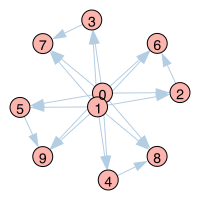

In [72]:
# Create simple network with 0 and 1 as the influential nodes
source = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,3,4,5]
target = [2,3,4,5,6,7,8,9,2,3,4,5,6,7,8,9,6,7,8,9]

g = ig.Graph(directed=True)
g.add_vertices(range(10))
g.add_edges(zip(source,target))

# Plot graph
g.vs["label"], g.es["color"], g.vs["color"] = range(10), "#B3CDE3", "#FBB4AE"
ig.plot(g,bbox = (200,200),margin = 20,layout = g.layout("kk"))

In [80]:
seed_celfpp = celf_pp(G, 3, .4)

33.903048276901245
69.98439979553223


In [81]:
seed_celf = celf(G, 3, .4, mc=2000)

30.693397045135498
22.82003402709961


In [82]:
seed_celfpp, seed_celf

([14, 20, 1], [14, 1, 6])

In [83]:
IC(G, seed_celf, .4), IC(G, seed_celfpp, .4)

(39.644, 39.491)

In [ ]:
# Run algorithms
greedy_output = greedy(G,3,p = 0.2,mc = 1000)

100%|██████████| 3/3 [06:27<00:00, 129.02s/it]


In [19]:
celf_output  = celf(g,3,p = 0.2,mc = 1000)

100%|██████████| 2/2 [02:29<00:00, 74.75s/it]


In [29]:
# Print results
print("celf output:   " + str(celf_output[0]))
print("greedy output: " + str(greedy_output[0]))

print("mean spread of celf:", celf_output[1][-1])
print("mean spread of greedy:", greedy_output[1][-1])

celf output:   [4, 72, 58]
greedy output: [4, 72, 58]
mean spread of celf: 63.673
mean spread of greedy: 63.673


In [21]:
# RR set sampling
def get_RRS(G, p):
    """
    Inputs:
        G: igraph Graph
        p: Propagation probability
    """
    source = choice(G.vs.indices)
    mask = np.random.uniform(0, 1, len(G.neighbors(source,mode="out"))) < p
    samp_G = np.array(G.get_edgelist())[np.random.uniform(0, 1, G.ecount()) < p]

    new_nodes, RRS0 = [source], [source]
    while new_nodes:
        tmp = [edge for edge in samp_G if edge[1] in new_nodes]
        tmp = [edge[0] for edge in tmp]
        RRS = list(set(RRS0+tmp))

        new_nodes = list(set(RRS) - set(RRS0))

        RRS0 = RRS
    return RRS

get_RRS(G, 0.3)

[10, 47]

In [11]:
for i in range(1, int(np.ceil(3.1))):
    print(i)

1
2
3


In [22]:
def TIM(G, k, p=.5, mc=1000, eps=0.05, l=1):
    n = G.vcount()
    m = G.ecount()
    st_time = time.time()
    kpt = kpt_estimation(G, k, p, l)
    lam = (8+2*eps)*n*(l*np.log(n) + np.log(comb(n, k)) + np.log(2))*np.power(eps, -2)
    theta = int(np.ceil(lam / kpt))
    R = [get_RRS() for i in range(theta)]
    SEED, timelapse = [], []

    for _ in range(k):
        flat_list = [item for sublist in R for item in sublist]
        seed = Counter(flat_list).most_common()[0][0]
        SEED.append(seed)
        R = [rrs for rrs in R if seed not in rrs]
        timelapse.append(time.time() - st_time)
    

def get_w(G, R):
    res = 0
    for node in R:
        G.indegree()[node]
    return res
        

def kpt_estimation(G, k, p, l):
    n = G.vcount()
    m = G.ecount()
    for i in range(1, int(np.ceil(np.log2(n)-1))):
        ci = (6*l*np.log(n) + 6*np.log(np.log2(n))) * np.power(2, i)
        _sum = 0
        for j in range(1, int(np.ceil(ci))):
            R = get_RRS(G, p)
            kappa = 1 - np.power(1 - get_w(G, R)/m, k)
            _sum += kappa
        if _sum / ci > 1 / np.power(2, i):
            return n*_sum/(2*ci)
        return 1


In [49]:
def RIS(G, k, p=.5, mc=1000):

    st_time = time.time()
    R = [get_RRS(G, p) for _ in range(mc)]

    SEED, timelapse = [], []

    for _ in range(k):
        flat_list = [item for sublist in R for item in sublist]
        seed = Counter(flat_list).most_common()[0][0]
        SEED.append(seed)

        R = [rrs for rrs in R if seed not in rrs]

        timelapse.append(time.time() - st_time)
    return SEED, timelapse

In [62]:
rr_output = RIS(g, 3, p=.2, mc=1000)
print("The seed set selected by RR-set:", rr_output[0])

The seed set selected by RR-set: [3, 4, 58]


In [68]:
rr_spread = [IC(G, rr_output[0][:i], p=.2) for i in range(1, 3+1)]

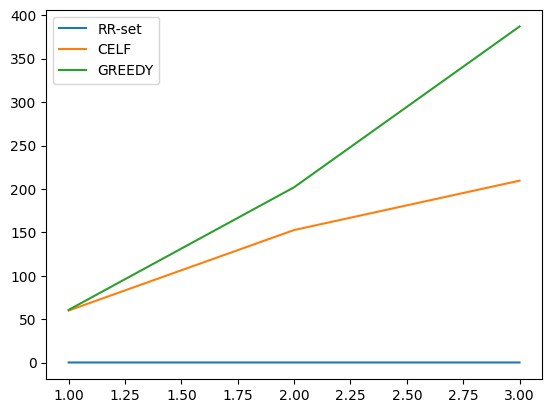

In [66]:
plt.figure()
plt.plot(range(1, len(rr_output[1])+1), rr_output[1], label="RR-set")
plt.plot(range(1, len(celf_output[2])+1), celf_output[2], label="CELF")
plt.plot(range(1, len(greedy_output[2])+1), greedy_output[2], label="GREEDY")
plt.xlabel("k")
plt.ylabel("Influence Spread")
plt.legend()
plt.show()

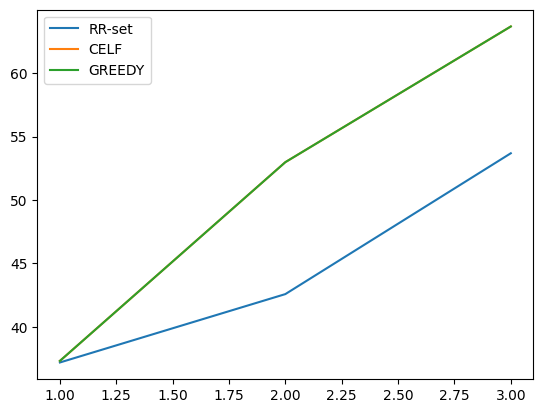

In [69]:
plt.figure()
plt.plot(range(1, len(rr_output[1])+1), rr_spread, label="RR-set")
plt.plot(range(1, len(celf_output[1])+1), celf_output[1], label="CELF")
plt.plot(range(1, len(greedy_output[1])+1), greedy_output[1], label="GREEDY")
plt.legend()
plt.show()

In [70]:
print("seed set selected by CELF:", celf_output[0])

seed set selected by CELF: [4, 72, 58]


# IMGraph Class
Stores the graph and integrates various functions

In [108]:
proxy_metrics = ["pagerank", "outdegree", "betweenness"]
method_marker = {
    "pagerank": 'o',
    "outdegree": "*",
    "betweenness": "x",
    "greedy": "+",
    "CELF": "s",
    "RIS": "D",
    "TIM": "p"
}
class IMGraph:
    def __init__(
        self,
        file_path: str, 
        p:float = .5,
        mc:int = 1000,
        eps:float = 0.2,
        l:int = 1,
        max_k = 5,
        k_step = 1
    ) -> None:
        self.file_path = file_path
        self.p = p
        self.mc = mc
        self.method_spread_map = {}
        self.method_seed_map = {}
        self.method_time_map = {}
        self.method_seed_idx = {}
        self.k = max_k
        self.eps = eps
        self.l = l
        self.k_list = [i for i in range(1, max_k+1, k_step)]
        try:
            self.G_nx = self.load_G_nx()
            
        except Exception as e:
            print("Failed to load the graph by networkx")
            print("Error:")
            print(e)
        try:
            self.G = ig.Graph.from_networkx(self.G_nx)
        except Exception as e:
            print("Failed to load the graph by networkx")
            print("Error:")
            print(e)
        self.n = self.G.vcount()
        self.m = self.G.ecount()
        return
    
    def test(self) -> None:
        print(self.file_path)
    
    def set_p(self, p) -> None:
        self.p = p
        return
    
    def load_G_nx(self) -> nx.Graph:
        if self.file_path.endswith("gml"):
            return nx.read_gml(self.file_path)
        if self.file_path.endswith("mtx"):
            return read_mtx(self.file_path)
        print("Cannot process such a file format")
        return None

    # Independent cascade model
    # Used to compute influence spread
    def IC(self, S) -> float:
        """
        Input:
            G: igraph Graph
            S: seed set
            p: probability threshold
            mc: number of MC simulations
        Output:
            average number of influenced nodes
        """
        spread = []     # The number of influenced nodes, starting from S
        # Loop for MC simulations
        for i in range(self.mc):
            # new_active: Newly activated nodes
            # A: all activated nodes
            new_active, A = S[:], S[:]

            # while there are newly added nodes
            while len(new_active) > 0:
                new_ones = []
                # For every newly activated nodes
                for node in new_active:
                    # Determine neighbors that become influenced
                    np.random.seed(i)       # set random seed
                    # sampling
                    success = np.random.uniform(0,1,len(self.G.neighbors(node,mode="out"))) < self.p
                    # newly activated nodes
                    new_ones += list(np.extract(success, self.G.neighbors(node,mode="out")))
                # compute the newly activated nodes
                new_active = list(set(new_ones) - set(A))
                
                # Add newly activated nodes to the set of activated nodes
                A += new_active
            # number of all activated nodes in this instance
            # print(i, len(A))
            spread.append(len(A))
        return np.mean(spread)
    
    def brute_force(self) -> None:
        SPREAD = []
        for k in tqdm(range(1, self.k+1)):
            combs = combinations(range(self.n), k)
            max_spread = 0
            max_seeds = []
            for c in tqdm(combs):
                cur_res = self.IC(list(c))
                if cur_res > max_spread:
                    max_spread = cur_res
                    max_seeds = c
            SPREAD.append(max_spread)
        self.method_spread_map["EXACT"] = SPREAD
        self.method_seed_idx["EXACT"] = max_seeds

    def proxy(self, proxy="pagerank") -> None:
        st_time = time.time()
        
        Q = zip(range(self.G.vcount()), getattr(self.G, proxy)())
        Q = sorted(Q, key = lambda x: x[1], reverse=True)

        SEED = [Q[i][0] for i in range(self.k)]

        self.method_time_map[proxy] = [time.time() - st_time]*len(self.k_list)

        spread = [self.IC(SEED[:i]) for i in self.k_list]
        self.method_spread_map[proxy] = spread
        self.method_seed_idx[proxy] = SEED
        self.method_seed_map[proxy] = [self.G.vs[idx]["_nx_name"] for idx in SEED]
        return
    
    def run_proxy_methods(self) -> None:
        for metric in proxy_metrics:
            self.proxy(metric)
        return
    # Greedy Algorithm
    def run_greedy(self) -> None:
        """
        Input:
            G: igraph Graph
            k: size of seed set
            p: threshold
            mc: number of mc simulation
        Output:
            S: solution seed set
            spread: number of influenced vertices
        """
        SEED, spread, timelapse, start_time = [], [], [], time.time()
        # loop for k nodes selection
        for _ in tqdm(range(self.k)):
            best_spread = 0    # initialization 
            # for every node that is not in S
            for j in set(range(self.G.vcount())) - set(SEED):
                s = self.IC(SEED+[j])
                if s > best_spread:
                    best_spread, node = s, j
            SEED.append(node)

            # Estimated spread and elapsed time
            spread.append(best_spread)
            timelapse.append(time.time() - start_time)
        self.method_spread_map["greedy"] = spread
        self.method_time_map["greedy"] = timelapse
        self.method_seed_idx["greedy"] = SEED
        self.method_seed_map["greedy"] = [self.G.vs[idx]["_nx_name"] for idx in SEED]
        return
    
    # Cost Effective Lazy Forward
    def run_celf(self):
        st_time = time.time()       # start time
        # marginal gain for every node
        # spread from every single node
        marg_gain = [self.IC([node]) for node in tqdm(range(self.n))]
        # sort the nodes by marginal gain
        Q = sorted(zip(range(self.n), marg_gain), key=lambda x: x[1], reverse=True)

        # seed set initialization: the first node
        # spread: number of all influenced nodes
        # SPREAD: # influenced nodes list
        S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
        Q, LOOKUPS, timelapse = Q[1:], [self.n], [time.time() - st_time]

        
        for _ in tqdm(range(self.k-1)):
            checked, node_lookup = False, 0
            # till the node with the highest MG does not change
            while not checked:
                node_lookup += 1    # The number of times the spread is computed
                current = Q[0][0]
                # calculate the MG of the current node
                Q[0] = (current, self.IC(S + [current]) - spread)
                Q = sorted(Q, key=lambda x: x[1], reverse=True)

                # if new MG is still the highest, exit the loop
                if Q[0][0] == current:
                    checked = True
                
            spread += Q[0][1]
            S.append(Q[0][0])
            SPREAD.append(spread)
            LOOKUPS.append(node_lookup)
            timelapse.append(time.time()-st_time)

            Q = Q[1:]
        self.method_spread_map["CELF"] = SPREAD
        self.method_time_map["CELF"] = timelapse
        self.method_seed_idx["CELF"] = S
        self.method_seed_map["CELF"] = [self.G.vs[idx]["_nx_name"] for idx in S]
        return
    
    def get_RRS(self):
        """
        Inputs:
            G: igraph Graph
            p: Propagation probability
        """
        source = choice(self.G.vs.indices)
        # mask = np.random.uniform(0, 1, len(self.G.neighbors(source,mode="out"))) < self.p
        samp_G = np.array(self.G.get_edgelist())[np.random.uniform(0, 1, self.m) < self.p]

        new_nodes, RRS0 = [source], [source]
        while new_nodes:
            tmp = [edge for edge in samp_G if edge[1] in new_nodes]
            tmp = [edge[0] for edge in tmp]
            RRS = list(set(RRS0+tmp))

            new_nodes = list(set(RRS) - set(RRS0))  # New nodes in the RR set

            RRS0 = RRS
        return RRS
    
    def run_RIS(self) -> None:
        st_time = time.time()
        R = [self.get_RRS() for _ in range(self.mc)]

        SEED, timelapse = [], []

        for _ in range(self.k):
            flat_list = [item for sublist in R for item in sublist]
            seed = Counter(flat_list).most_common()[0][0]
            SEED.append(seed)
            R = [rrs for rrs in R if seed not in rrs]
            timelapse.append(time.time() - st_time)
        
        # self.method_spread_map["RIS"] = SPREAD
        self.method_time_map["RIS"] = timelapse
        self.method_seed_idx["RIS"] = SEED
        self.method_seed_map["RIS"] = [self.G.vs[idx]["_nx_name"] for idx in SEED]
        return
    def run_TIM(self):
        n, k, eps, l = self.n, self.k, self.eps, self.l
        
        st_time = time.time()
        kpt = self.kpt_estimation()
        lam = (8+2*self.eps)*self.n*(l*np.log(n) + np.log(comb(n, k)) + np.log(2))*np.power(eps, -2)
        theta = int(np.ceil(lam / kpt))
        print(theta)
        R = [self.get_RRS() for _ in range(theta)]
        SEED, timelapse = [], []

        for _ in range(self.k):
            flat_list = [item for sublist in R for item in sublist]
            seed = Counter(flat_list).most_common()[0][0]
            SEED.append(seed)
            R = [rrs for rrs in R if seed not in rrs]
            timelapse.append(time.time() - st_time)
        self.method_time_map["TIM"] = timelapse
        self.method_seed_idx["TIM"] = SEED
        self.method_seed_map["TIM"] = [self.G.vs[idx]["_nx_name"] for idx in SEED]
    
    def get_w(self, R):
        res = 0
        for node in R:
            self.G.indegree()[node]
        return res
            

    def kpt_estimation(self):
        for i in range(1, int(np.ceil(np.log2(self.n)-1))):
            ci = (6*self.l*np.log(self.n) + 6*np.log(np.log2(self.n))) * np.power(2, i)
            _sum = 0
            for j in range(1, int(np.ceil(ci))):
                R = self.get_RRS()
                kappa = 1 - np.power(1 - self.get_w(R)/self.m, self.k)
                _sum += kappa
            if _sum / ci > 1 / np.power(2, i):
                return self.n*_sum/(2*ci)
            return 1

    
    def estimate_spread(self, method:str) -> None:
        SPREAD = []
        S = self.method_seed_idx[method]
        for i in range(len(S)):
            SPREAD.append(self.IC(S[:i+1]))
        self.method_spread_map[method] = SPREAD
        return

    

In [122]:
font = {'family': 'serif',
        'weight': 'normal',
        }

def vis_methods_spread(IM_G:IMGraph, **kwargs) -> None:
    fig_size = (8, 6)
    if "figsize" in kwargs.keys():
        fig_size= kwargs["figsize"]
    plt.figure(figsize=fig_size)

    for method in IM_G.method_spread_map.keys():
        plt.plot(IM_G.k_list, IM_G.method_spread_map[method],  marker=method_marker[method], label=method, markersize=8, mfc="None", linewidth=1)
        
    plt.legend()
    plt.title("Resulting Influence Spread of Different Methods", size=15, fontdict=font)
    plt.xticks(IM_G.k_list)
    plt.xlabel(r"$k$", size=10)
    plt.ylabel("Expected Spread", size=10, fontdict=font)
    plt.show()

def vis_methods_time(IM_G:IMGraph, **kwargs) -> None:
    fig_size = (8, 6)
    if "figsize" in kwargs.keys():
        fig_size= kwargs["figsize"]
    plt.figure(figsize=fig_size)

    for method in IM_G.method_time_map.keys():
        plt.plot(IM_G.k_list, IM_G.method_time_map[method],  marker=method_marker[method], label=method, markersize=8, mfc="None", linewidth=1)
        
    plt.legend()
    plt.title("Time Cost of Different Methods", size=15)
    plt.xticks(IM_G.k_list)
    plt.xlabel(r"$k$", size=10)
    plt.ylabel("Expected Spread", size=10)
    plt.show()

In [117]:
test_G = IMGraph(dolphin_file_name, mc=5000, max_k=5, eps=.8)
test_G.run_proxy_methods()

In [114]:
test_G2 = IMGraph(dolphin_file_name, mc=1000)
test_G2.run_greedy()

100%|██████████| 5/5 [01:44<00:00, 20.96s/it]


In [118]:
test_G.run_greedy()

100%|██████████| 5/5 [08:44<00:00, 104.96s/it]


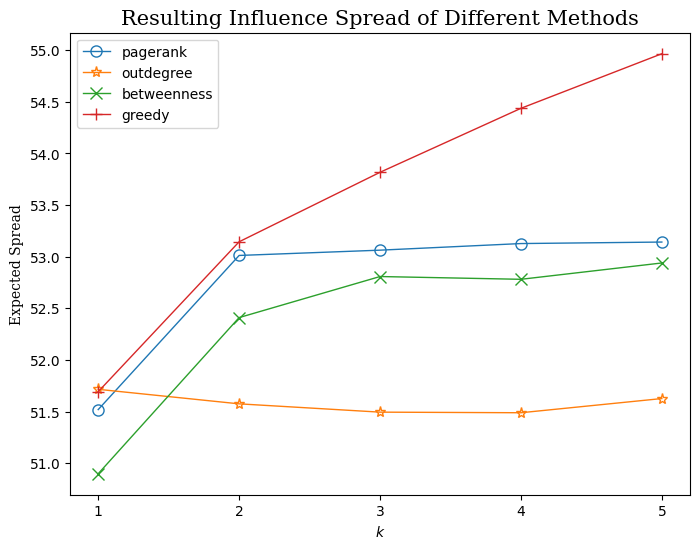

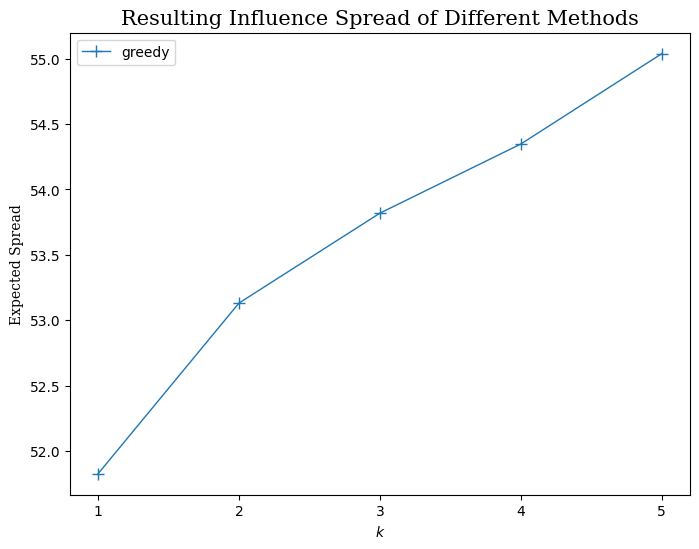

In [123]:
vis_methods_spread(test_G)
vis_methods_spread(test_G2)

In [99]:
test_G.run_celf()

100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


In [100]:
test_G.run_RIS()

In [101]:
test_G.estimate_spread("RIS")

In [102]:
test_G.run_TIM()

19068


In [103]:
test_G.estimate_spread("TIM")

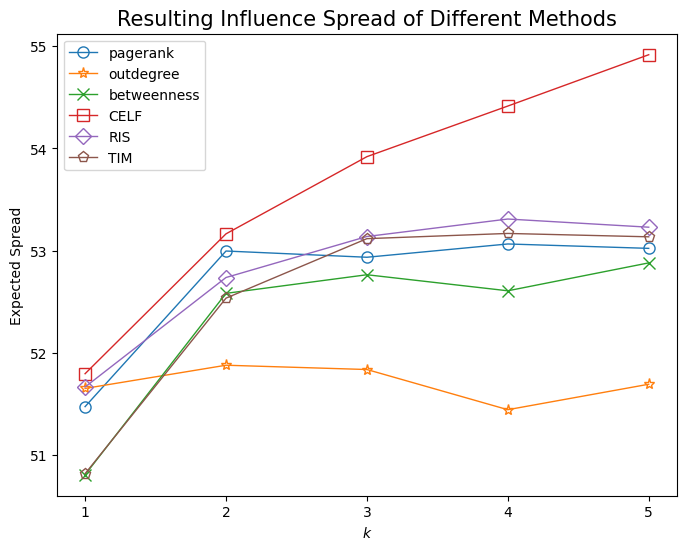

In [94]:
vis_methods_spread(test_G)

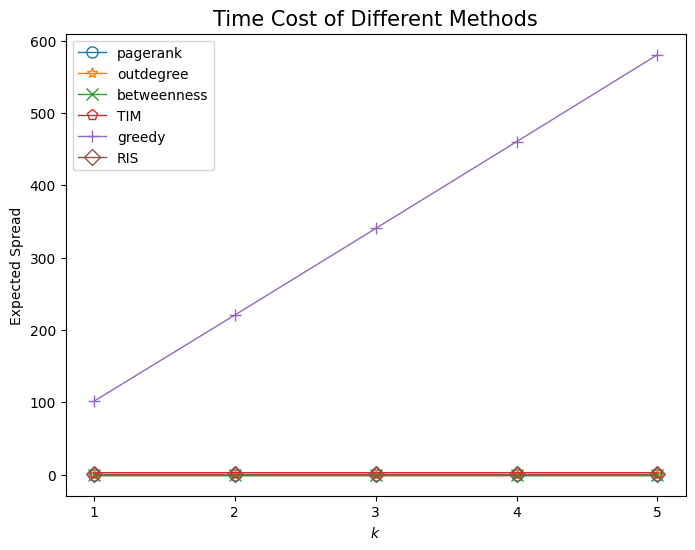

In [77]:
vis_methods_time(test_G)

In [31]:
G.outdegree() == G.degree()

True

In [190]:
cnt = 0
for i in range(30):
    if(IC(G, [14, 37, 45]) < IC(G, [14, 37])):
        cnt += 1
print(cnt)

17


In [62]:
e = .7
k = 5
n=70
(8*k**2 + 2*k*e)*(2*np.log(n)+np.log(k))/e**2

4269.450363433252